In [17]:
### HW5 Geostatistics ###
# Created by: Anna Grunes
# 10/8/24

import pandas as pd
import os
import numpy as np
#import matplotlib.pyplot as plt
from scipy import stats
import itertools as it
import matplotlib

import matplotlib.pyplot as plt 

from geostats_functions import * #pulling in functions from geostats_functions.py file
## To see functions, open geostats_functions.py

#Information regarding these functions can be found in the docstrings (type 'help(my_function)')
help(semivariogram_equal_bin_widths) #Example




Help on function semivariogram_equal_bin_widths in module geostats_functions:

semivariogram_equal_bin_widths(pairs_df, bin_width, fit_model, model_func, **model_pars)
    'Semivariogram with equal width of bins
    pairs_df = DataFrame with pairs,distance, and corresponding semivariance
    bin_width = User-specified width of bins (singel value or a list)
    fit_model = Fit a model to the semivariogram (True or False)
    model_func = Which model function to fit
    if fit_model == True, add in arguments for range (a) and sill (omega)



In [2]:
#Ensure correct directory
os.getcwd()

#Upload dataset
berea_subset = pd.read_csv('Berea_subset2.csv')
n = len(berea_subset)
print(f'Number of data points = {n}')
units = {'Water Resistivity':'ohm-m',
        'Permeability':'mD'}
#check for nans
berea_subset.isnull().sum()

#Shorten to make calling columns easier
perm = 'Permeability (mD)'
res = 'Water Resisitivity ohm-m'
x = 'x (mm)'
y = 'y (mm)'

# PRIMARY = Permeability
# SECONDARY = Resistivity 

Number of data points = 403


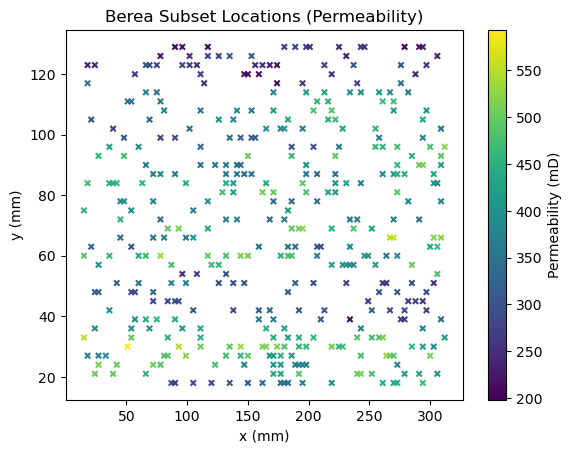

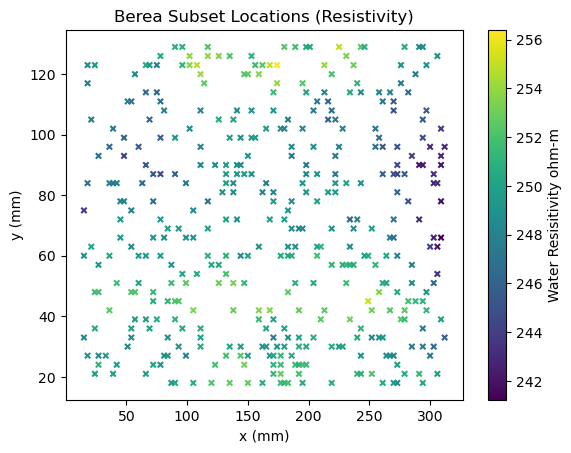

In [3]:
#Visualizing this subset

#Permeability
plt.scatter(berea_subset['x (mm)'], berea_subset['y (mm)'], s = 15, marker='x', c = berea_subset['Permeability (mD)'])
plt.colorbar(label='Permeability (mD)')
plt.title('Berea Subset Locations (Permeability)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

#Resistivity
plt.scatter(berea_subset['x (mm)'], berea_subset['y (mm)'], s = 15, marker='x', c = berea_subset[res])
plt.colorbar(label=res)
plt.title('Berea Subset Locations (Resistivity)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

In [4]:
N_h = int(((n-1)*(n))/2) #Find number of unique data pairs
print(f'n = {n} Data Points')
print(f'N(h) = {N_h} Data Pairs')

n = 403 Data Points
N(h) = 81003 Data Pairs


In [6]:
# Generate all unique pairs of data points (n=403, N(h)=81003)
pairs = list(it.combinations(berea_subset.index, 2))
pairs_df = pd.DataFrame([(berea_subset.loc[i, x], berea_subset.loc[i, y],
                          berea_subset.loc[j, x], berea_subset.loc[j, y])
                          for i, j in pairs],
                        columns=['x1', 'y1', 'x2','y2'])#f'{perm}_1',f'{res}_1','x2', 'y2',f'{perm}_2',f'{res}_2'])

In [7]:
dist = calc_euclidean_dist(2,3,5,6)#,z1=10,z2=4)
#CHecking euclidean distance function
#This should work with z-values too!


In [8]:
#pre-allocating pairs dataframe
pairs_df['Distance']=[np.nan]*len(pairs_df)
pairs_df[f'{perm}_1']=[np.nan]*len(pairs_df)
pairs_df[f'{res}_1']=[np.nan]*len(pairs_df)
pairs_df[f'{perm}_2']=[np.nan]*len(pairs_df)
pairs_df[f'{res}_2']=[np.nan]*len(pairs_df)
pairs_df['Semivariance']=[np.nan]*len(pairs_df)


In [9]:
try:
    pairs_df=pd.read_csv('pairs_df.csv') #See if this has already been done so it takes less time to go through
    #    the whole thing
except: #If the csv does not already exist, calculate the statistics for each pair
    for i,row in pairs_df.iterrows():
        dist=calc_euclidean_dist(x1=row['x1'],y1=row['y1'],x2=row['x2'],y2=row['y2']) #calculate distance between each pair
        pairs_df.loc[i,'Distance']=dist #bring into DF
        x_a = row['x1']
        y_a = row['y1']
        sub = berea_subset[(berea_subset[x]==x_a) & (berea_subset[y]==y_a)] 
        pairs_df.loc[i,f'{perm}_1']=list(sub[perm]) #bring in corresponding Permeability for pt.1
        pairs_df.loc[i,f'{res}_1']=list(sub[res]) #Bring in corresponding Resistivity for pt.1
        x_a = row['x2']
        y_a = row['y2']
        sub = berea_subset[(berea_subset[x]==x_a) & (berea_subset[y]==y_a)]
        pairs_df.loc[i,f'{perm}_2']=list(sub[perm]) #bring in corresponding Permeability for pt.2
        pairs_df.loc[i,f'{res}_2']=list(sub[res]) #Bring in corresponding Resistivity for pt.2
        
    for i,row in pairs_df.iterrows():
        semivar = calc_semivar_individual(row[f'{perm}_1'],row[f'{perm}_2']) #give each pair an associated semivariance
        pairs_df.loc[i,'Semivariance']=semivar
    pairs_df.to_csv('pairs_df.csv')

In [34]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    '''Creating scatter plots with histograms on both the 
    x and y axes'''
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha = 0.5,s=10, lw=0)
    ax.set_xlabel('Distance [mm]')
    ax.set_ylabel('Semivariance [\u03B3]')

    ax_histx.hist(x, bins=30)
    ax_histy.hist(y, bins=30, orientation='horizontal')
    


C:\Users\agrunes\AppData\Local\Temp\ipykernel_18368\2711942768.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


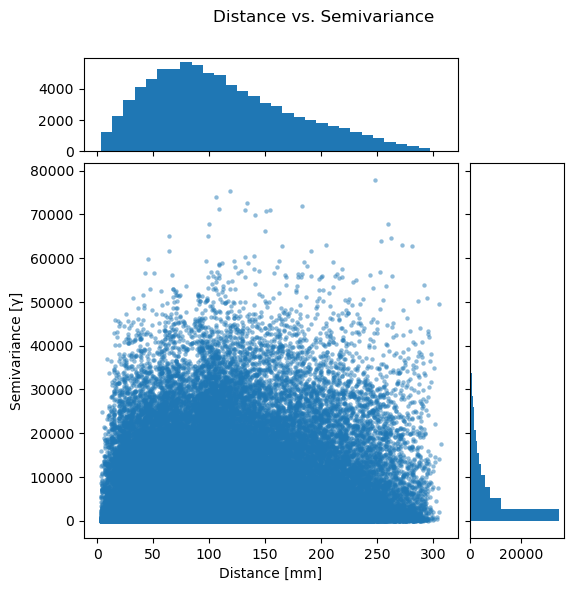

In [35]:

#Plotting Distance vs. Semivariance
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                    left=0.1, right=0.9, bottom=0.1, top=0.9,
                    wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(x=pairs_df['Distance'], y=pairs_df['Semivariance'], ax=ax, ax_histx=ax_histx, ax_histy=ax_histy)
fig.suptitle(f'Distance vs. Semivariance')
plt.tight_layout()
plt.show()

In [36]:
N_h

81003

In [12]:
##### --- i) Equal number of points in bin
n_bins = np.sqrt(N_h)
n_bins_int=int(n_bins)
print(f'{n_bins:.0f} points in each bin for equal number of pts in each bin')
print(f'{N_h/n_bins:.2f} bins')
min_dist = min(pairs_df['Distance'])
max_dist=max(pairs_df['Distance'])
print('Min',min_dist)
print('Max',max_dist)
bins = np.linspace(min_dist,int(max_dist)+1,n_bins_int)

285 points in each bin for equal number of pts in each bin
284.61 bins
Min 3.0
Max 307.46707140765494


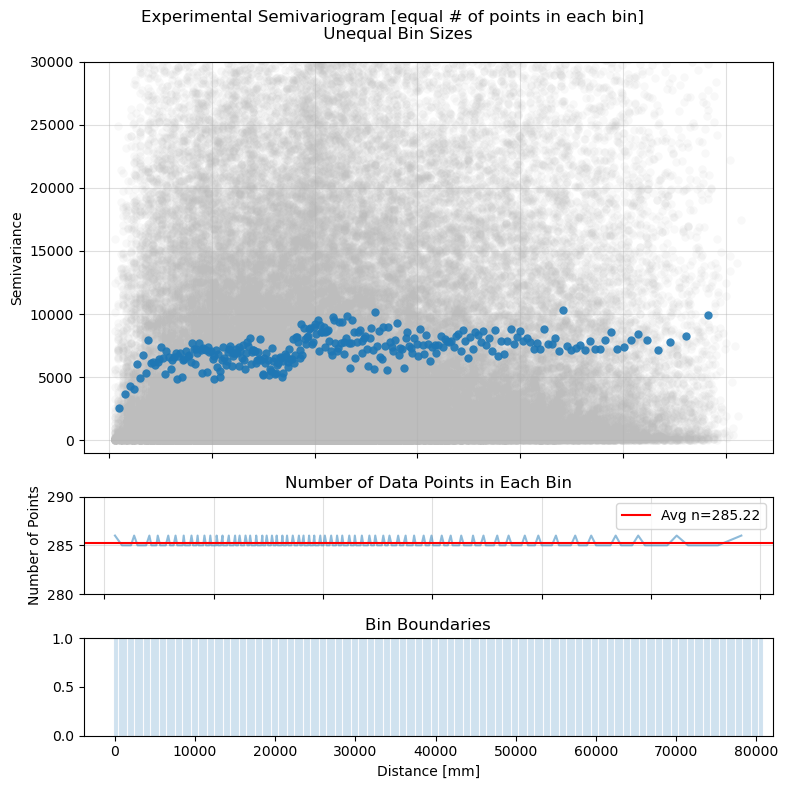

In [20]:
##### --- i) Equal number of points in bin
# Calling the function to place an equal number of data points in each bin
semivariogram_equal_points(pairs_df=pairs_df, n_bins = n_bins_int,fit_model=False, model_func=apply_gaussian_model, omega=8000,a = 25)

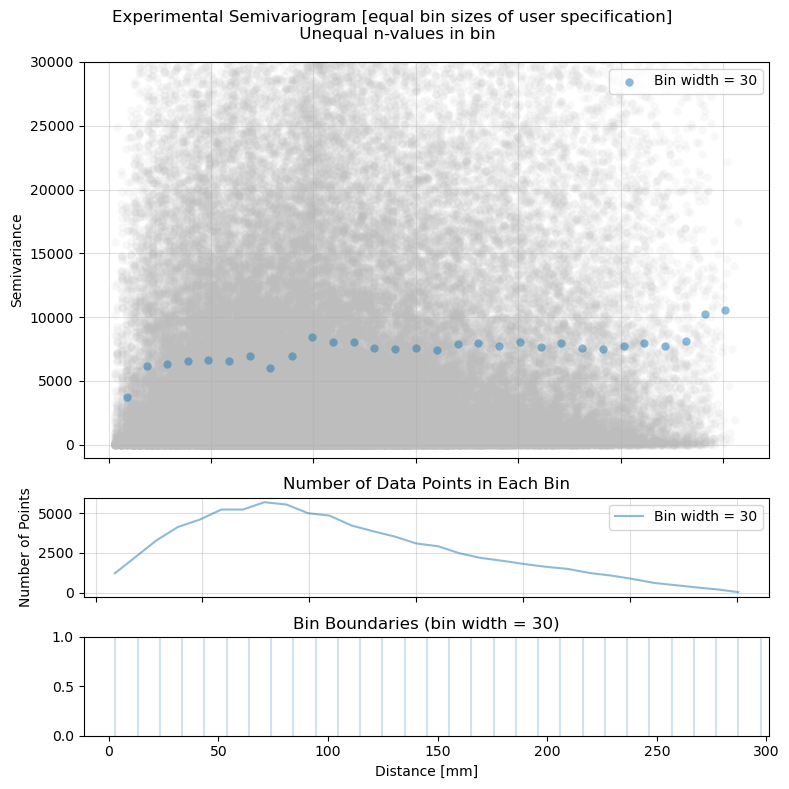

In [47]:
##### --- ii) Equal bin width (user specified)
# Calling the function to make bins of an equal width, specified by the function input bin_width
semivariogram_equal_bin_widths(pairs_df, bin_width=30, fit_model=False, model_func=apply_spherical_model, omega=7000,a=15)

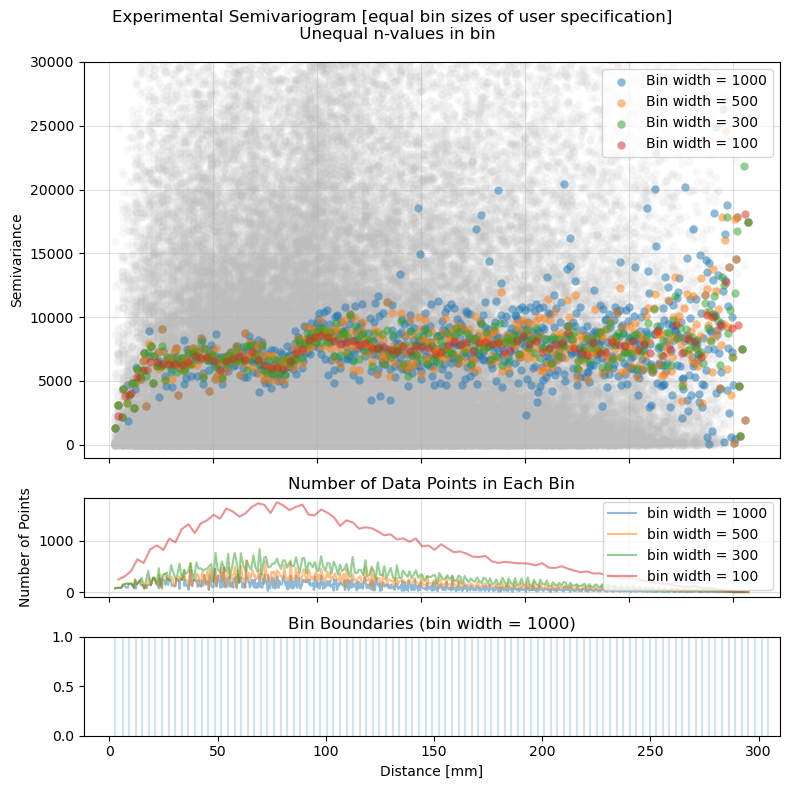

In [22]:
##### --- ii) Equal bin width (user specified)
# Calling the function to make bins of an equal width, specified by the function input bin_width
# Showing that bin_width can also be a list of widths to explore how these change
semivariogram_equal_bin_widths(pairs_df, bin_width=[1000,500,300,100], fit_model=False, model_func=apply_spherical_model, omega=7000,a=15)

### iii) **Interactive, user specified bins**
##### Grabs bin boundaries from bin_breaks_interactive.txt
To go into an interactive graph and select breakpoints for bins, open the interactive.py file. 
1. Specify the number of bins you would like to select by adjusting the `n` variable
2. Run `interactive.py` in **terminal** by typing `python interactive.py` in the `HW5` directory
3. A plot will pop up, here you will select the distance values where you would like a bin break. The y-coordinate does not matter. 
4. When you have finished, the program completes and you can close the graph. 
5. Return to this JupyterNB, and run the following cell. 
6. The following plot shows the semivariogram at the points at which you specified. 

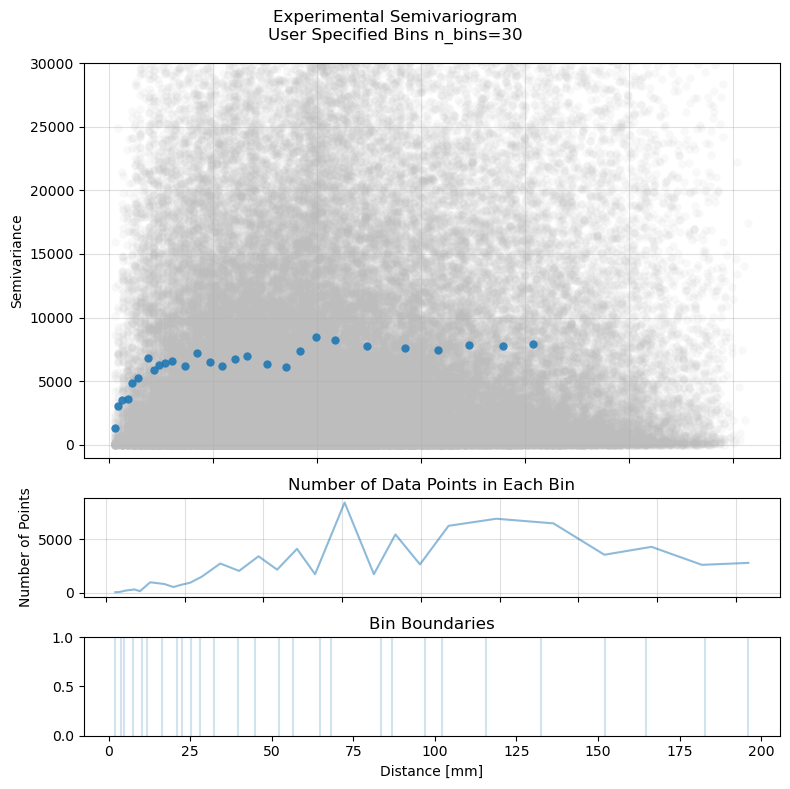

In [52]:

semivariogram_interactive_bins(pairs_df, bin_breaks_file='bin_breaks_interactive.txt', fit_model=False, model_func=apply_spherical_model, omega=8000,a=30)

### 3) **Add in the option to fit by models to the semivariograms by eye** 
##### For any of the functions above, the argument `fit_model` can be set to `True`. 
##### Then, set `model_func` to the model function that you want. The options are:
1. `apply_spherical_model`
2. `apply_exponential_model`
3. `apply_gaussian_model`

##### Then, adjust the `omega` (sill) and `a` (range) input parameters to fit the model by eye. 
##### Adjust iteratively to fit model.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


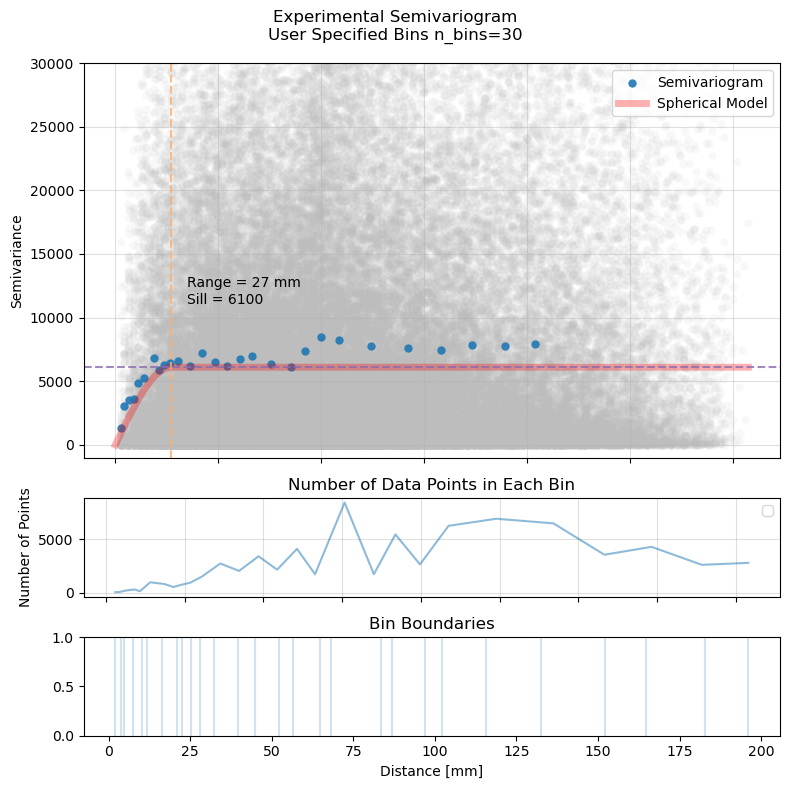

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


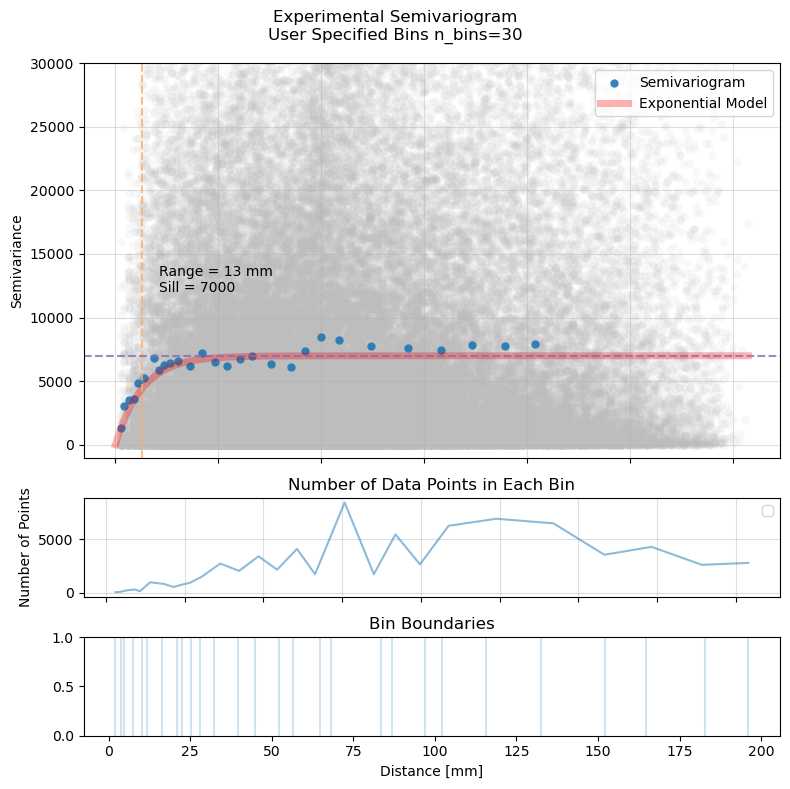

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


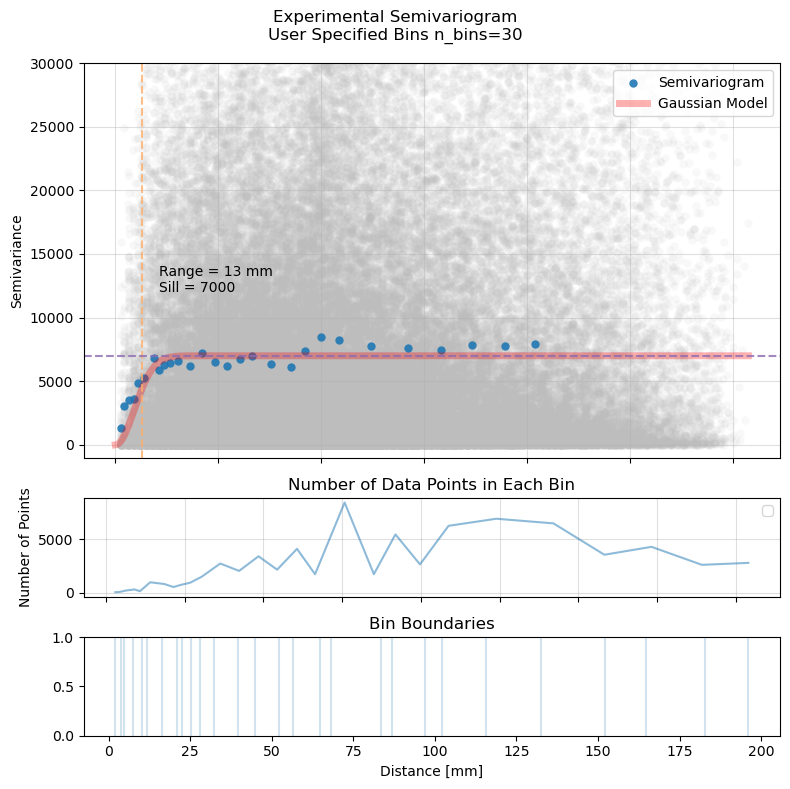

In [51]:
### 3) Add in the option to fit by models to the semivariograms by eye 
# For example, I will fit each model to the user-specified bin breaks semivariogram.
semivariogram_interactive_bins(pairs_df, bin_breaks_file='bin_breaks_interactive.txt', fit_model=True, model_func=apply_spherical_model, omega=6100,a=27)
semivariogram_interactive_bins(pairs_df, bin_breaks_file='bin_breaks_interactive.txt', fit_model=True, model_func=apply_exponential_model, omega=7000,a=13)
semivariogram_interactive_bins(pairs_df, bin_breaks_file='bin_breaks_interactive.txt', fit_model=True, model_func=apply_gaussian_model, omega=7000,a=13)

